# Level 5: Agents & MCP Tools

This notebook is for developers who are already familiar with [basic agent workflows](Level2_simple_agent_with_websearch.ipynb). 
Here, we will highlight more advanced use cases for agents where a single tool call is insufficient to complete the required task.

We will also use [MCP tools](https://github.com/modelcontextprotocol/servers) (which can be deployed onto an OpenShift cluster) throughout this demo to show users how to extend their agents beyond Llama Stacks's current builtin tools and connect to many different services and data sources to build their own custom agents.  

### Agent Example:

This notebook will walkthrough how to build a system that can answer the following question via an agent built with Llama Stack:

- *"Review OpenShift logs for pod-123 and pod-456. Categorize each as either ‘Normal’ or ‘Error’. If any are considered to be ‘Error’, send a Slack message to the ops team. Otherwise, show a simple summary."*


### MCP Tools:

#### OpenShift MCP Server

Throughout this notebook we will be relying on the [kubernetes-mcp-server](https://github.com/manusa/kubernetes-mcp-server) by [manusa](https://github.com/manusa) to interact with our OpenShift cluster. Please see installation instructions below if you do not already have this deployed in your environment. 

* [OpenShift MCP installation instructions](../../../kubernetes/mcp-servers/openshift-mcp/README.md)

#### Slack MCP Server
We will also be using the [Slack MCP Server](https://github.com/modelcontextprotocol/servers-archived/tree/main/src/slack) in this notebook. Please see installation instructions below if you do not already have this deployed in your environment. 

* [Slack MCP installation instructions](../../../kubernetes/mcp-servers/slack-mcp/README.md)

## Pre-Requisites

Before starting this notebook, ensure that you have:
- Followed the instructions in the [Setup Guide](./Level0_getting_started_with_Llama_Stack.ipynb) notebook.
- Access to an OpeShift cluster with a deployment of the [OpenShift MCP server](https://github.com/opendatahub-io/llama-stack-demos/tree/main/kubernetes/mcp-servers/openshift-mcp) (see the [deployment manifests](https://github.com/opendatahub-io/llama-stack-on-ocp/tree/main/kubernetes/mcp-servers/openshift-mcp) for assistance with this).
- A Tavily API key is required. You can register for one at https://app.tavily.com/home.

## Setting Up this Notebook
We will initialize our environment as described in detail in our ["Getting Started" notebook](./Level0_getting_started_with_Llama_Stack.ipynb). Please refer to it for additional explanations.

In [1]:
# for accessing the environment variables
import os
from dotenv import load_dotenv
load_dotenv()

# for communication with Llama Stack
from llama_stack_client import LlamaStackClient
from llama_stack_client import Agent
from llama_stack_client.lib.agents.react.agent import ReActAgent
from llama_stack_client.lib.agents.react.tool_parser import ReActOutput
from llama_stack_client.lib.agents.event_logger import EventLogger

# pretty print of the results returned from the model/agent
from termcolor import cprint
import sys
sys.path.append('..')  
from src.utils import step_printer

base_url = os.getenv("REMOTE_BASE_URL")


# Tavily search API key is required for some of our demos and must be provided to the client upon initialization.
# We will cover it in the agentic demos that use the respective tool. Please ignore this parameter for all other demos.
tavily_search_api_key = os.getenv("TAVILY_SEARCH_API_KEY")
if tavily_search_api_key is None:
    provider_data = None
else:
    provider_data = {"tavily_search_api_key": tavily_search_api_key}


client = LlamaStackClient(
    base_url=base_url,
    provider_data=provider_data
)

print(f"Connected to Llama Stack server")

# model_id for the model you wish to use that is configured with the Llama Stack server
model_id = "granite32-8b"

temperature = float(os.getenv("TEMPERATURE", 0.0))
if temperature > 0.0:
    top_p = float(os.getenv("TOP_P", 0.95))
    strategy = {"type": "top_p", "temperature": temperature, "top_p": top_p}
else:
    strategy = {"type": "greedy"}

max_tokens = 512

# sampling_params will later be used to pass the parameters to Llama Stack Agents/Inference APIs
sampling_params = {
    "strategy": strategy,
    "max_tokens": max_tokens,
}

stream_env = os.getenv("STREAM", "False")
# the Boolean 'stream' parameter will later be passed to Llama Stack Agents/Inference APIs
# any value non equal to 'False' will be considered as 'True'
stream = (stream_env != "False")

print(f"Inference Parameters:\n\tModel: {model_id}\n\tSampling Parameters: {sampling_params}\n\tstream: {stream}")

Connected to Llama Stack server
Inference Parameters:
	Model: granite32-8b
	Sampling Parameters: {'strategy': {'type': 'greedy'}, 'max_tokens': 512}
	stream: False


## Validate tools are available in our Llama Stack instance

When an instance of Llama Stack is redeployed, it may be the case that the tools will need to be re-registered. Also if a tool is already registered with a Llama Stack instance, trying to register another one with the same `toolgroup_id` will throw you an error.

For this reason, it is recommended to validate your tools and toolgroups. The following code will check that both the `builtin::websearch`, `mcp::openshift`  and `mcp::slack` tools are correctly registered, and if not it will attempt to register them using their specific endpoints.

In [2]:
ocp_mcp_url = os.getenv("REMOTE_OCP_MCP_URL") 
slack_mcp_url = os.getenv("REMOTE_SLACK_MCP_URL")

registered_tools = client.tools.list()
registered_toolgroups = [t.toolgroup_id for t in registered_tools]
if "mcp::openshift" not in registered_toolgroups:
    client.toolgroups.register(
        toolgroup_id="mcp::openshift",
        provider_id="model-context-protocol",
        mcp_endpoint={"uri":ocp_mcp_url},
    )

if "mcp::slack" not in registered_toolgroups:
    client.toolgroups.register(
        toolgroup_id="mcp::slack",
        provider_id="model-context-protocol",
        mcp_endpoint={"uri":slack_mcp_url},
   )
print(f"Your Llama Stack server is registered with the following tool groups @ {set(registered_toolgroups)} \n")

Your Llama Stack server is registered with the following tool groups @ {'mcp::slack', 'mcp::openshift', 'builtin::rag', 'builtin::websearch'} 



## Defining our Agent - Prompt Chaining

In [3]:
model_prompt= """You are a helpful assistant. You have access to a number of tools.
Whenever a tool is called, be sure to return the Response in a friendly and helpful tone.
"""

### Deploy a pod with simulated error logs

For the purpose of testing and retrieving logs from a pod exhibiting errors, we will deploy a pod on an OpenShift cluster that produces simulated error logs. We have a pre-built container image available for this "fake" error pod that you can use. With the help of the agent and the OpenShift MCP server we can deploy the pod as follows.

In [4]:
# Create simple agent with tools
agent = Agent(
    client,
    model= model_id,  # replace this with model_id to get the value of INFERENCE_MODEL_ID environment variable
    instructions = model_prompt , # update system prompt based on the model you are using
    tools=["mcp::openshift"],
    tool_config={"tool_choice":"auto"},
    sampling_params=sampling_params
)

user_prompts = ["Create a pod called slack-test in the llama-serve namespace using the quay.io/redhat-et/failing-test-pod:latest image"]
session_id = agent.create_session(session_name="OCP_Slack_demo")

for i, prompt in enumerate(user_prompts):
    response = agent.create_turn(
        messages=[
            {
                "role":"user",
                "content": prompt
            }
        ],
        session_id=session_id,
        stream=stream,
    )
    if stream:
        for log in EventLogger().log(response):
            log.print()
    else:
        step_printer(response.steps) # print the steps of an agent's response in a formatted way. 


---------- 📍 Step 1: InferenceStep ----------
🛠️ Tool call Generated:
Tool call: pods_run, Arguments: {'image': 'quay.io/redhat-et/failing-test-pod:latest', 'name': 'slack-test', 'namespace': 'llama-serve'}

---------- 📍 Step 2: ToolExecutionStep ----------
🔧 Executing tool...


{
│   'type': 'text',
│   'text': '# The following resources (YAML) have been created or updated successfully\n- apiVersion: v1\n  kind: Pod\n  metadata:\n    annotations:\n      openshift.io/scc: restricted-v2\n      seccomp.security.alpha.kubernetes.io/pod: runtime/default\n    creationTimestamp: "2025-05-14T17:32:18Z"\n    labels:\n      app.kubernetes.io/component: slack-test\n      app.kubernetes.io/managed-by: kubernetes-mcp-server\n      app.kubernetes.io/name: slack-test\n      app.kubernetes.io/part-of: kubernetes-mcp-server-run-sandbox\n    name: slack-test\n    namespace: llama-serve\n    resourceVersion: "939283880"\n    uid: ffe8d370-23cd-42ae-897a-d6c2dfabf1c7\n  spec:\n    containers:\n    - image: quay.io/redhat-et/failing-test-pod:latest\n      imagePullPolicy: Always\n      name: slack-test\n      resources: {}\n      securityContext:\n        allowPrivilegeEscalation: false\n        capabilities:\n          drop:\n          - ALL\n        runAsNonRoot: true\n        runAsUser: 1001770000\n      terminationMessagePath: /dev/termination-log\n      terminationMessagePolicy: File\n      volumeMounts:\n      - mountPath: /var/run/secrets/kubernetes.io/serviceaccount\n        name: kube-api-access-2tlqt\n        readOnly: true\n    dnsPolicy: ClusterFirst\n    enableServiceLinks: true\n    imagePullSecrets:\n    - name: default-dockercfg-bxwvb\n    preemptionPolicy: PreemptLowerPriority\n    priority: 0\n    restartPolicy: Always\n    schedulerName: default-scheduler\n    securityContext:\n      fsGroup: 1001770000\n      seLinuxOptions:\n        level: s0:c42,c24\n      seccompProfile:\n        type: RuntimeDefault\n    serviceAccount: default\n    serviceAccountName: default\n    terminationGracePeriodSeconds: 30\n    tolerations:\n    - effect: NoExecute\n      key: node.kubernetes.io/not-ready\n      operator: Exists\n      tolerationSeconds: 300\n    - effect: NoExecute\n      key: node.kubernetes.io/unreachable\n      operator: Exists\n      tolerationSeconds: 300\n    volumes:\n    - name: kube-api-access-2tlqt\n      projected:\n        defaultMode: 420\n        sources:\n        - serviceAccountToken:\n            expirationSeconds: 3607\n            path: token\n        - configMap:\n            items:\n            - key: ca.crt\n              path: ca.crt\n            name: kube-root-ca.crt\n        - downwardAPI:\n            items:\n            - fieldRef:\n                apiVersion: v1\n                fieldPath: metadata.namespace\n              path: namespace\n        - configMap:\n            items:\n            - key: service-ca.crt\n              path: service-ca.crt\n            name: openshift-service-ca.crt\n  status:\n    phase: Pending\n    qosClass: BestEffort\n',
│   'annotations': None
}


---------- 📍 Step 3: InferenceStep ----------
🤖 Model Response:
The pod named "slack-test" using the image "quay.io/redhat-et/failing-test-pod:latest" has been successfully created in the "llama-serve" namespace. Here are the details:

```yaml
apiVersion: v1
kind: Pod
metadata:
  annotations:
    openshift.io/scc: restricted-v2
    seccomp.security.alpha.kubernetes.io/pod: runtime/default
  creationTimestamp: "2025-05-14T17:32:18Z"
  labels:
    app.kubernetes.io/component: slack-test
    app.kubernetes.io/managed-by: kubernetes-mcp-server
    app.kubernetes.io/name: slack-test
    app.kubernetes.io/part-of: kubernetes-mcp-server-run-sandbox
  name: slack-test
  namespace: llama-serve
  resourceVersion: "939283880"
  uid: ffe8d370-23cd-42ae-897a-d6c2dfabf1c7
spec:
  containers:
  - image: quay.io/redhat-et/failing-test-pod:latest
    imagePullPolicy: Always
    name: slack-test
    resources: {}
    securityContext:
      allowPrivilegeEscalation: false
      capabilities:
        dro

You should see a pod `slack-test` successfully deployed in your namespace on the OpenShift cluster. If you view the logs of the pod, you should see the simulated error message as follows:
```
Starting container...
Failure: Unknown Error
Error details: Container failed due to an unexpected issue during startup.
Potential cause: Missing dependencies, configuration errors, or permission issues.
```

### Retrieve logs for erroneous pods running on OpenShift and send a message to Slack

Now that we have a simulated erroneous pod running on the OpenShift cluster, we can task the agent with summarizing the logs and sending a message to Slack.

In [5]:
# Create simple agent with tools
agent = Agent(
    client,
    model= model_id,  # replace this with model_id to get the value of INFERENCE_MODEL_ID environment variable
    instructions = model_prompt , # update system prompt based on the model you are using
    tools=["mcp::openshift", "mcp::slack"],
    tool_config={"tool_choice":"auto"},
    sampling_params=sampling_params
)

user_prompts = ["View the logs for pod slack-test in the llama-serve OpenShift namespace. Categorize it as normal or error.",
               "Summarize the results with the pod name, category along with a briefly explanation as to why you categorized it as normal or error. Respond with plain text only. Do not wrap your response in additional quotation marks.",
               "Send a message with the summarization to the demos channel on Slack."]
session_id = agent.create_session(session_name="OCP_Slack_demo")

for i, prompt in enumerate(user_prompts):
    response = agent.create_turn(
        messages=[
            {
                "role":"user",
                "content": prompt
            }
        ],
        session_id=session_id,
        stream=stream,
    )
    if stream:
        for log in EventLogger().log(response):
            log.print()
    else:
        step_printer(response.steps) # print the steps of an agent's response in a formatted way. 


---------- 📍 Step 1: InferenceStep ----------
🛠️ Tool call Generated:
Tool call: pods_log, Arguments: {'name': 'slack-test', 'namespace': 'llama-serve'}

---------- 📍 Step 2: ToolExecutionStep ----------
🔧 Executing tool...


{
│   'type': 'text',
│   'text': 'Starting container...\nFailure: Unknown Error\nError details: Container failed due to an unexpected issue during startup.\nPotential cause: Missing dependencies, configuration errors, or permission issues.\n',
│   'annotations': None
}


---------- 📍 Step 3: InferenceStep ----------
🤖 Model Response:
The logs for the pod `slack-test` in the `llama-serve` OpenShift namespace indicate an error. The container failed due to an unexpected issue during startup. This could be due to missing dependencies, configuration errors, or permission issues.

========== Query processing completed ========== 


---------- 📍 Step 1: InferenceStep ----------
🤖 Model Response:
Pod Name: slack-test
Category: Error
Explanation: The container failed due to an unexpected issue during startup. This could be due to missing dependencies, configuration errors, or permission issues.

========== Query processing completed ========== 


---------- 📍 Step 1: InferenceStep ----------
🛠️ Tool call Generated:
Tool call: slack_post_message, Arguments: {'channel_id': 'demos', 'text': 'Pod Name: slack-test\nCategory: Error\nExplanation: The container failed due to an unexpected issue during startup. This could be due to missing dependencies, configuration e

{
│   'type': 'text',
│   'text': '{"ok":true,"channel":"C08MUDSNHED","ts":"1747243980.236359","message":{"user":"U08MM2P7BEF","type":"message","ts":"1747243980.236359","bot_id":"B08MM2P60KV","app_id":"A08MLQCUGUS","text":"Pod Name: slack-test\\nCategory: Error\\nExplanation: The container failed due to an unexpected issue during startup. This could be due to missing dependencies, configuration errors, or permission issues.","team":"T08M9UTL2DC","bot_profile":{"id":"B08MM2P60KV","app_id":"A08MLQCUGUS","user_id":"U08MM2P7BEF","name":"et-slack-bot","icons":{"image_36":"https://a.slack-edge.com/80588/img/plugins/app/bot_36.png","image_48":"https://a.slack-edge.com/80588/img/plugins/app/bot_48.png","image_72":"https://a.slack-edge.com/80588/img/plugins/app/service_72.png"},"deleted":false,"updated":1744227670,"team_id":"T08M9UTL2DC"},"blocks":[{"type":"rich_text","block_id":"9udo=","elements":[{"type":"rich_text_section","elements":[{"type":"text","text":"Pod Name: slack-test\\nCategory: Error\\nExplanation: The container failed due to an unexpected issue during startup. This could be due to missing dependencies, configuration errors, or permission issues."}]}]}]},"warning":"missing_charset","response_metadata":{"warnings":["missing_charset"]}}',
│   'annotations': None
}


---------- 📍 Step 3: InferenceStep ----------
🤖 Model Response:
The message has been successfully posted to the `demos` channel on Slack:

```
Pod Name: slack-test
Category: Error
Explanation: The container failed due to an unexpected issue during startup. This could be due to missing dependencies, configuration errors, or permission issues.
```

========== Query processing completed ========== 



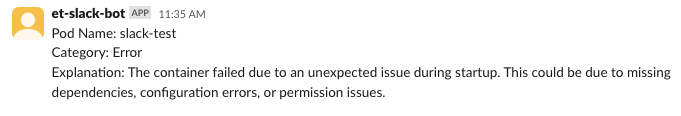

In [6]:
from IPython.display import Image, display

display(Image(filename='./images/slack-message.png'))

In the screenshot above, you can see that our `et-slack-bot`,which is configured to both our public Slack workspace and the Slack MCP server, successfully posted a pod status summary message to the #demos channel.

### Output Analysis

Lets step through the output to further understands whats happening in this notebook.

1. First the LLM generated a tool call for the `pods_log` tool included in the **OpenShift MCP server** and fetched the logs for the specified pod.
2. The tool successfully retrieved the logs for the pod.
3. The LLM  then received the logs from the tool call, along with the original query.
4. This context was then passed back to the LLM for the final inference. The inference result provided a summary of the pod logs along with its category of 'Normal' or 'Error'.
5. Finally, the summary of the pod logs is sent as a Slack message using the `slack_post_message` tool configured with the **Slack MCP Server**.

## Defining our Agent - ReAct

Now that we've shown that we can successfully accomplish this multi-step multi-tool task using prompt chaining, let's see if we can give our agent a bit more autonomy to perform the same task but with a single prompt instead of a chain. To do this, we will instantiate a **ReAct agent** (which is included in the llama stack python client by default).The ReAct agent is a variant of the simple agent but with the ability to loop through "Reason then Act" iterations, thinking through the problem and then using tools until it determines that it's task has been completed successfully.  

Unlike prompt chaining which follows fixed steps, ReAct dynamically breaks down tasks and adapts its approach based on the results of each step. This makes it more flexible and capable of handling complex, real-world queries effectively.

Below you will see the slight differences in the agent definition and the prompt used to accomplish our task.

In [7]:
agent = ReActAgent(
            client=client,
            model=model_id,
            tools=["mcp::slack","mcp::openshift"],
            response_format={
                "type": "json_schema",
                "json_schema": ReActOutput.model_json_schema(),
            },
            sampling_params={"max_tokens":512},
        )
user_prompts =["""Review the OpenShift logs for the pod 'slack-test' in the 'llama-serve' namespace and generate a summary of any errors.
               Finally send a clearly formatted message with items pod name, category and explanation to the Slack channel with demo_id `demos`."""]
session_id = agent.create_session("web-session")
for prompt in user_prompts:
    print("\n"+"="*50)
    cprint(f"Processing user query: {prompt}", "blue")
    print("="*50)
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
        stream=stream
    )
    if stream:
        for log in EventLogger().log(response):
            log.print()
    else:
        step_printer(response.steps) # print the steps of an agent's response in a formatted way. 


Processing user query: Review the OpenShift logs for the pod 'slack-test' in the 'llama-serve' namespace and generate a summary of any errors.
               Finally send a clearly formatted message with items pod name, category and explanation to the Slack channel with demo_id `demos`.

---------- 📍 Step 1: InferenceStep ----------
🤖 Model Response:
{
    "thought": "I need to first get the logs of the pod 'slack-test' in the 'llama-serve' namespace using the `pods_log` tool. Then, I will analyze these logs to find any errors. After that, I will use the `slack_post_message` tool to send a summary of the errors to the Slack channel with demo_id `demos`.",
    "action": {
        "tool_name": "pods_log",
        "tool_params": [{"name": "name", "value": "slack-test"}, {"name": "namespace", "value": "llama-serve"}]
    },
    "answer": null
}


---------- 📍 Step 2: ToolExecutionStep ----------
🔧 Executing tool...


{
│   'type': 'text',
│   'text': 'Starting container...\nFailure: Unknown Error\nError details: Container failed due to an unexpected issue during startup.\nPotential cause: Missing dependencies, configuration errors, or permission issues.\n',
│   'annotations': None
}


---------- 📍 Step 3: InferenceStep ----------
🤖 Model Response:
{
    "thought": "I found an error in the logs: 'Failure: Unknown Error'. I will now summarize this information and send it to the Slack channel with demo_id `demos` using the `slack_post_message` tool.",
    "action": {
        "tool_name": "slack_post_message",
        "tool_params": [
            {"name": "channel_id", "value": "demos"},
            {"name": "text", "value": "Pod Name: slack-test\nCategory: Error\nExplanation: The pod failed due to an unexpected issue during startup. Potential causes include missing dependencies, configuration errors, or permission issues."}
        ]
    },
    "answer": null
}


---------- 📍 Step 4: ToolExecutionStep ----------
🔧 Executing tool...


{
│   'type': 'text',
│   'text': '{"ok":true,"channel":"C08MUDSNHED","ts":"1747244089.508789","message":{"user":"U08MM2P7BEF","type":"message","ts":"1747244089.508789","bot_id":"B08MM2P60KV","app_id":"A08MLQCUGUS","text":"Pod Name: slack-test\\nCategory: Error\\nExplanation: The pod failed due to an unexpected issue during startup. Potential causes include missing dependencies, configuration errors, or permission issues.","team":"T08M9UTL2DC","bot_profile":{"id":"B08MM2P60KV","app_id":"A08MLQCUGUS","user_id":"U08MM2P7BEF","name":"et-slack-bot","icons":{"image_36":"https://a.slack-edge.com/80588/img/plugins/app/bot_36.png","image_48":"https://a.slack-edge.com/80588/img/plugins/app/bot_48.png","image_72":"https://a.slack-edge.com/80588/img/plugins/app/service_72.png"},"deleted":false,"updated":1744227670,"team_id":"T08M9UTL2DC"},"blocks":[{"type":"rich_text","block_id":"EdD6","elements":[{"type":"rich_text_section","elements":[{"type":"text","text":"Pod Name: slack-test\\nCategory: Error\\nExplanation: The pod failed due to an unexpected issue during startup. Potential causes include missing dependencies, configuration errors, or permission issues."}]}]}]},"warning":"missing_charset","response_metadata":{"warnings":["missing_charset"]}}',
│   'annotations': None
}


---------- 📍 Step 5: InferenceStep ----------
🤖 Model Response:
{
    "thought": "The message has been successfully posted to the Slack channel with demo_id `demos`.",
    "action": null,
    "answer": "The message has been successfully posted to the Slack channel with demo_id `demos`."
}

========== Query processing completed ========== 



### Output Analysis

Above, we can see that the ReAct agent took nearly an identical approach to the prompt chaining method above, but using a single prompt instead of a chain.  

1. First the LLM generated a tool call for the `pods_log` tool included in the **OpenShift MCP server** and fetched the logs for the specified pod.
2. The tool successfully retrieved the logs for the pod.
3. The LLM  then received the logs from the tool call, along with the original query.
4. This context was then passed back to the LLM for the final inference. The inference result provided a summary of the pod logs along with its category of 'Normal' or 'Error'.
5. Finally, the summary of the pod logs is sent as a Slack message using the `slack_post_message` tool configured with the **Slack MCP Server**.

## Key Takeaways

This notebook demonstrated how to build an agentic MCP applications with Llama Stack. We did this by initializing an agent with access to two MCP servers that were registered to our Llama Stack server, then invoked the agent on our specified set of queries. We showed that we can do this with more directed Prompt Chaining or with the more open ended ReAct pattern. Please check out our next notebooks, [Agents, MCP and RAG](Level6_agents_MCP_and_RAG.ipynb) for more examples of extending your agents capabilities with Llama Stack.

#### Any Feedback?

If you have any feedback on this or any other notebook in this demo series we'd love to hear it! Please go to https://www.feedback.redhat.com/jfe/form/SV_8pQsoy0U9Ccqsvk and help us improve our demos. 